In [2]:
import sys
sys.path.append('..')
import jax
from jax import vmap
import numpy as np
from src.util import *
from src.plot import *
import matplotlib.pyplot as plt

if False:
    for j in range(100):
        clist = []
        M = 1000
        for i in range(M):
            print(f"{i+1}/{M}", end='\r')
            clist.append(loop_erased_rw())
            
        data = jnp.array(clist)
        jnp.save(f'data_{j}.npy', data)

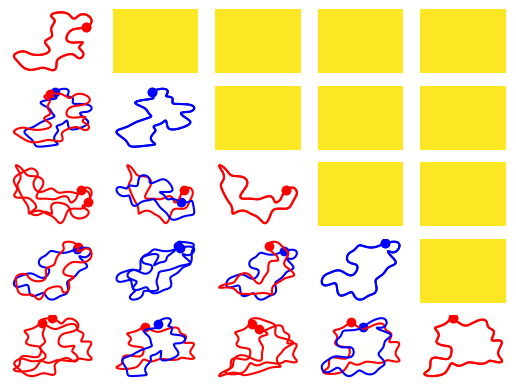

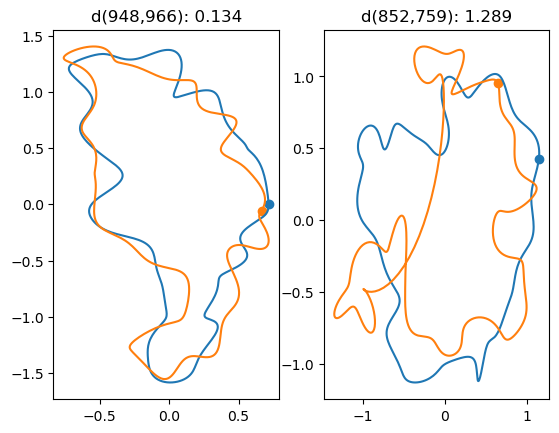

In [3]:
Nref = 100
clist = jnp.load('data.npy')

def plot_corr_table(width, clist, Nref=40):
    for i in range(width):
        for j in range(i+1):
            col1 = "red" if i % 2 == 0 else "blue"
            col2 = "red" if j % 2 == 0 else "blue"
            c1 = clist[i]
            c2 = clist[j]
            c21 = align_fourier(c2, c1, Nref=Nref)        
            dist = error(c1, c21)
            
            plt.subplot(width, width, i*width+j+1)
            plot_fourier_curve(c1, color=col1)
            plot_fourier_curve(c21, color=col2)
            plt.axis("off")
            
            ax = plt.subplot(width, width, j*width+i+1)
            # Color background according to distance
            ax.set_facecolor(plt.cm.viridis(dist/0.01))
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])

def get_dist_table(clist1, clist2=None, Nref=40):
    if clist2 is None:
        clist2 = clist1
    distance_wrap = lambda x1, x2: distance(x1, x2, Nref=Nref)
    return vmap(vmap(distance_wrap, (0, None)), (None, 0))(clist1, clist2)

def get_table_min(table):
    table_mask = jnp.where(jnp.identity(table.shape[0]), jnp.nan, table)
    idx_min = jnp.nanargmin(table_mask)
    (row_min, col_min) = jnp.unravel_index(idx_min, table.shape)
    return row_min, col_min

def get_table_max(table):
    table_mask = jnp.where(jnp.identity(table.shape[0]), jnp.nan, table)
    idx_max = jnp.nanargmax(table_mask)
    (row_max, col_max) = jnp.unravel_index(idx_max, table.shape)
    return row_max, col_max

plot_corr_table(5, clist, Nref=Nref)

batches = 1
N = 1000
table = jnp.zeros((batches*N, batches*N))
for b1 in range(batches):
    for b2 in range(batches):
        c1 = jnp.load(f'data_{b1}.npy')
        c2 = jnp.load(f'data_{b2}.npy')
        table = table.at[b1*N:(b1+1)*N, b2*N:(b2+1)*N].set(get_dist_table(c2, c1, Nref=Nref))
    
#table = get_dist_table(clist, Nref=Nref)
row_min, col_min = get_table_min(table)
row_max, col_max = get_table_max(table)

bi_min, bj_min = row_min // N, col_min // N
i_min, j_min = row_min % N, col_min % N

bi_max, bj_max = row_max // N, col_max // N
i_max, j_max = row_max % N, col_max % N

plt.figure()
for itern, (i, j, bi, bj) in enumerate(zip([i_min, i_max], [j_min, j_max], [bi_min, bi_max], [bj_min, bj_max])):
    #print(f"Min: ({i}, {j}) - ({bi}, {bj})")
    c1 = jnp.load(f"data_{bi}.npy")[i]
    c2 = jnp.load(f"data_{bj}.npy")[j]
    c21 = align_fourier(c2, c1, Nref=Nref)        
    dist = error(c1, c21)
    
    plt.subplot(1, 2, itern+1)
    plot_fourier_curve(c1)
    plot_fourier_curve(c21)
    plt.title(f"d({i},{j}): {dist:.3f}")
    

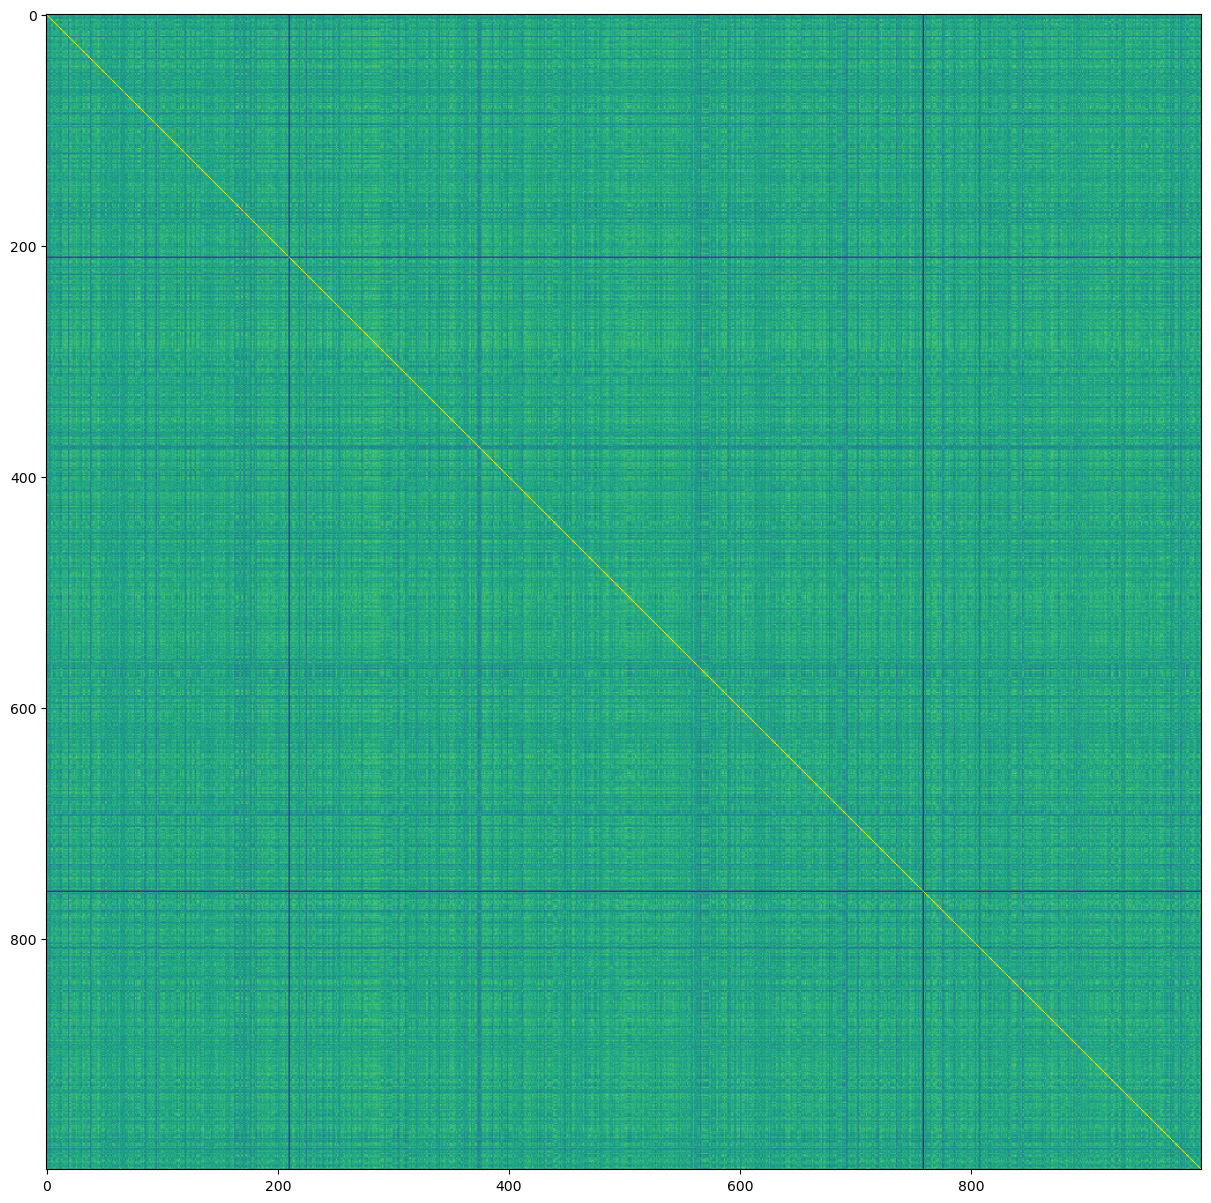

In [4]:
plt.figure(figsize=(15,15))
plt.imshow(np.exp(-table))

In [87]:
from jax import grad, jacrev, vmap, jit
import jax.numpy as jnp
from jax.lax import cond
from jax.scipy.linalg import lu_factor, lu_solve

def integrate(f, t, w):
    return jnp.sum(f(t)*w)

def curve_integral(f, g, t, w):
    return integrate(vmap(lambda s: f(s)*norm(jacrev(g)(s))), t, w)

def kernel_integral(f, k, g, t, w):
    return vmap(lambda r: curve_integral(lambda s: k(r, s) @ f(s), g, t, w))(t)

def mlp_solution(q, g, t, w, eta):
    slp = slp_solution(q, g, t, w)
    dlp = dlp_solution(q, g, t, w)
    return lambda x: eta * slp(x) + dlp(x)

def mlp_matrix(g, t, w, eta):
    return dlp_matrix(g, t, w) + slp_matrix(g, t, w)*eta

def slp_matrix(g, t, w):
    dg = lambda t: norm(jacrev(g)(t))
    integrand = lambda t, s: stokeslet(g(t) - g(s)) * dg(s)
    integrand_ = lambda t, s: cond(s!=t, integrand, lambda *args: jnp.zeros((2,2)), t, s)
    matrix = jnp.einsum("ijkl, j -> ijkl", vmap(vmap(integrand_, (None, 0)), (0, None))(t, t), w)
    return matrix / (4*jnp.pi)

def slp_solution(q, g, t, w):
    dg = lambda t: norm(jacrev(g)(t))
    integrand = lambda x, s: stokeslet(x - g(s)) * dg(s)
    def solution(x):
        integrand_x = vmap(lambda s: integrand(x, s)/ (4*jnp.pi))(t) 
        return jnp.einsum("ijk, ik -> j", integrand_x, q*w[:, None])
    return solution

def dlp_matrix(g, t, w):
    n = normal(g)
    dg = lambda t: norm(jacrev(g)(t))
    integrand = lambda t, s: jnp.einsum("ijk,k->ij", stresslet(g(t) - g(s)), n(s)) * dg(s)
    integrand_ = lambda t, s: cond(s!=t, integrand, lambda *args: jnp.zeros((2,2)), t, s)
    matrix = jnp.einsum("ijkl, j -> ijkl", vmap(vmap(integrand_, (None, 0)), (0, None))(t, t), w)
    Idmat = jnp.einsum("ij,kl->ijkl", jnp.eye(len(t)), jnp.eye(2))
    return matrix/(4*jnp.pi) - Idmat * 0.5
    
def dlp_solution(q, g, t, w):
    n = normal(g)
    dg = lambda t: norm(jacrev(g)(t))
    integrand = lambda x, s: jnp.einsum("ijk,k->ij", stresslet(x - g(s)), n(s))*dg(s)
    def solution(x):
        integrand_x = vmap(lambda s: integrand(x, s)/(4*jnp.pi))(t)
        return jnp.einsum("ijk, ik -> j", integrand_x, q*w[:, None])
    return solution
    
def stokeslet(r):
    abs_r = norm(r)
    c1 = -jnp.log(abs_r) * jnp.eye(2)
    c2 = jnp.einsum("i,j->ij", r, r)/ abs_r**2
    return c1 + c2
    
def stresslet(r):
    abs_r = norm(r)
    return -4*jnp.einsum("i,j,k->ijk", r, r, r) / abs_r**4

def rotmat(theta):  
    return jnp.array([[jnp.cos(theta), -jnp.sin(theta)], [jnp.sin(theta), jnp.cos(theta)]])

def norm(r):
    return jnp.linalg.norm(r, axis=0)

def normalize(g):
    return g / norm(g)

def normal(g):
    return lambda t: jnp.einsum("ij,j->i", rotmat(-jnp.pi/2), normalize(jacrev(g)(t)))

def from_complex(z):
    return jnp.array([z.real, z.imag])

def stackmatrix(mat):
    return jnp.vstack([jnp.hstack([mat[:, :, i, j] for j in range(2)]) for i in range(2)])

def stackvector(vec):
    return jnp.vstack([vec[:, i, None] for i in range(2)])

def unstackvector(vec):
    N = len(vec)//2
    return jnp.hstack([vec[:N], vec[N:]])
    
def fourier_eval_flat(t, c):
    K = (len(c)-1)//2
    ks = jnp.arange(-K, K+1)
    E = jnp.exp(1j * ks * t)
    return jnp.sum(E * c.flatten())

def constant_vector_field(uinf, t):
    return vmap(lambda _: uinf)(t)

def force(q, g, t, w):
    return vmap(lambda v: curve_integral(lambda t: 1., g, t, v*w), (1))(q)

def streamplot(X, Y, U, V, *args, **kwargs):
    X = np.array(X)
    Y = np.array(Y)
    U = np.array(U)
    V = np.array(V)
    plt.streamplot(X, Y, U, V, *args, **kwargs)

In [204]:
c = jnp.load('data_0.npy')[4]
N = 802
eta = 0.5

t = jnp.linspace(0, 2*jnp.pi, N+1)[:-1]
w = jnp.ones(N) * 2*jnp.pi / N
g = lambda t: from_complex(fourier_eval_flat(t, c))
#g = lambda t: jnp.array([1*jnp.cos(-t), 3*jnp.sin(-t)])

mat = stackmatrix(mlp_matrix(g, t, w, eta))
lu_sol = lu_factor(mat)

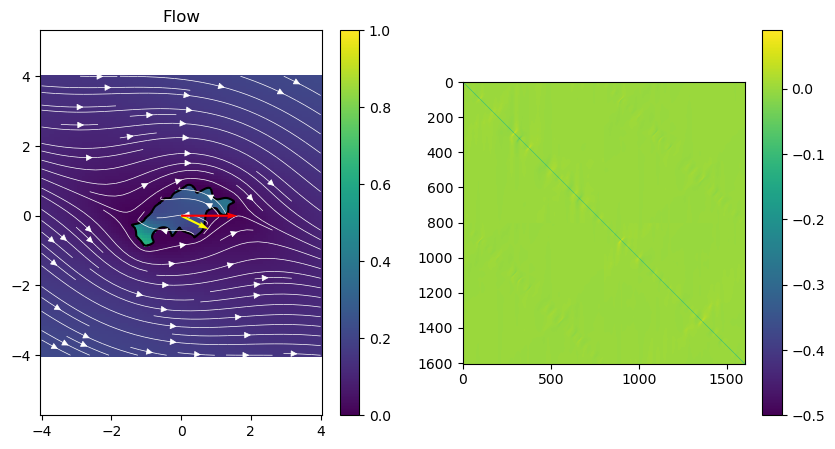

In [205]:
#get_rhs = lambda theta: stackvector(constant_vector_field(uinf, t))
uinf = from_complex(jnp.exp(1j*jnp.pi/2*0))
rhs = stackvector(constant_vector_field(-uinf, t))

q = unstackvector(lu_solve(lu_sol, rhs))
F = -force(q, g, t, w)

sol = mlp_solution(q, g, t, w, eta)
sol_xy = lambda x, y: sol(jnp.array([x, y]))

x = jnp.linspace(-4, 4, 100)
y = jnp.linspace(-4, 4, 100)
X, Y = jnp.meshgrid(x, y)
u = vmap(vmap(sol_xy, (0, 0)), (0, 0))(X, Y)
u_x = vmap(sol_xy, (0, None))(x, 0)
U = u[:, :, 0] + uinf[0]
V = u[:, :, 1] + uinf[1]

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.title("Flow")
z = vmap(g)(t)
plt.plot(z[:,0], z[:,1], color="black")
plt.pcolormesh(X, Y, (U**2 + V**2)**0.5, vmin=0, vmax=20)
streamplot(X, Y, U, V, color="white", linewidth=0.5)
#plt.quiver(X, Y, U, V, scale=20)
plt.quiver(0, 0, F[0], F[1], color="yellow", scale=500, zorder=100)
plt.quiver(0, 0, uinf[0], uinf[1], color="red", scale=5, zorder=100)
plt.axis("equal")
plt.colorbar()

plt.subplot(122)
plt.imshow(mat)
plt.colorbar()


(-1.0965951949357986,
 1.0998378664255142,
 -1.0991079211235046,
 1.0991079211235046)

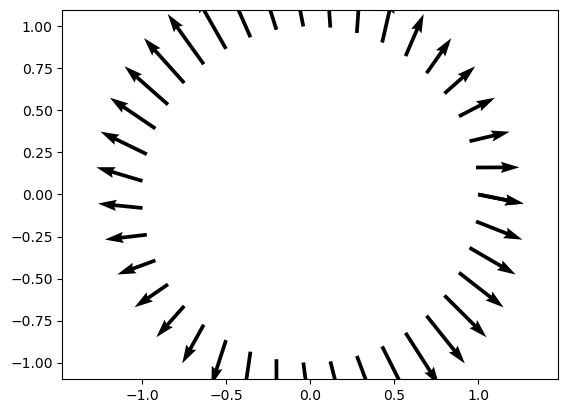

In [203]:
def force_at_angle(theta):
    uinf = from_complex(jnp.exp(1j*theta))
    rhs = stackvector(constant_vector_field(-uinf, t))
    q = unstackvector(lu_solve(lu_sol, rhs))
    return -force(q, g, t, w)


t_forces = jnp.linspace(0, 2*jnp.pi, 40)
forces = vmap(force_at_angle)(t_forces)
plt.quiver(jnp.cos(t_forces), jnp.sin(t_forces), forces[:, 0], forces[:, 1], scale=800)
plt.axis("equal")
